In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

***
# Baseline Model training and testing
### In this phase we extract the benign and malicious samples from the DReLAB dataset. The samples are then used to train the baseline model based on RandomForestClassifier. In this way, we obtain a high-performance botnet classifier, capable to effectively detect the botnet traffic for the selected botnet.

### Possible dataset choices: **"CTU", "BOTNET", "CICIDS2018"**
#### Possible Botnet choices according to the dataset:
- CTU:
    - "Neris"
    - "Rbot"
    - "Virut"
    - "Menti"
    - "Murlo"
    
- CICIDS2018:
    - "Zeus_Ares"

- BOTNET:
    - "Neris"
    - "Rbot"
    - "Virut"
    - "Menti"
    - "Murlo"

In [2]:
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1)

In [3]:
# Select here the Dataset and the botnet
ds = "CTU"
botnet = "Neris"

In [5]:
# Get benign samples from the selected dataset ds
ben = pd.read_csv("DReLAB/{}/benign.csv".format(ds), index_col = 0)

n_ben = len(ben)
print(n_ben)

2582434


In [6]:
# Get malicious samples belonging to the chosen botnet from the selected dataset
mal = pd.read_csv("DReLAB/{}/malicious/{}.csv".format(ds, botnet), index_col = 0)
n_mal = len(mal)
print(n_mal)

60632


In [8]:
# Obtain the dataset in a 20:1 benign/malicious ratio

if (n_ben // 20) >= n_mal:
    dataset_ben = ben.sample(n_mal * 20)
    dataset = pd.concat([dataset_ben, mal], ignore_index = True)
    print("Benign in dataset: {}".format(len(dataset_ben)))
    print("Malicious in dataset: {}".format(len(mal)))
    print("Ben / Mal Ratio: {}".format(len(dataset_ben) / len(mal)))
else:
    dataset_mal = mal.sample(n_ben // 20)
    dataset = pd.concat([ben, dataset_mal], ignore_index = True)
    print("Benign in dataset: {}".format(len(ben)))
    print("Malicious in dataset: {}".format(len(dataset_mal)))
    print("Ben / Mal Ratio: {}".format(len(ben) / len(dataset_mal)))

Benign in dataset: 1212640
Malicious in dataset: 60632
Ben / Mal Ratio: 20.0


In [9]:
dataset.head()

,IPSrcType,IPDstType,Dur,Proto,sTos,dTos,OutBytes,InBytes,TotPkts,TotBytes,...,>,<-,<->,SrcPort_Private,SrcPort_Registered,SrcPort_Well_Known,DstPort_Private,DstPort_Registered,DstPort_Well_Known,Label
0,1,0,15.074506,0,0.0,0.0,246,126,6,372,...,0,0.0,0,1,0,0,0,0,1,0
1,0,1,0.635263,0,0.0,0.0,124,120,4,244,...,0,0.0,0,1,0,0,0,1,0,0
2,0,1,15.188370,0,0.0,0.0,1840,7840,18,9680,...,0,0.0,0,0,1,0,0,0,1,0
3,1,0,11.415746,0,0.0,0.0,1441,28834,40,30275,...,0,0.0,0,1,0,0,0,0,1,0
4,0,1,9.029517,0,0.0,0.0,234,0,3,234,...,0,0.0,0,0,1,0,0,1,0,0


In [10]:
# Training the model

X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = ["Label"]), dataset.Label, shuffle = True)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [11]:
# Obtain predictions

pred = model.predict(X_test)

In [12]:
# Compute f1, precision and recall score.

f1 = f1_score(y_test, pred)
prec = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

print("F1 score: {}".format(f1))
print("Precision Score: {}".format(prec))
print("Recall Score (Detection Rate): {}".format(recall))

F1 score: 0.9468845418246485
Precision Score: 0.9597333696095769
Recall Score (Detection Rate): 0.9343752069399378


***

# Adversarial Evasion

### In this phase we extract the adversarial samples from the DReLAB dataset belonging to the preselected botnet family. We then submit such adversarial samples to the previously trained detector and the Detection Rate will severely drop with respect to the Detection Rate obtained in absence of adversarial attacks.

### Possible Deep Reinforcement Learning agent choices: **"DDQN" (Double Deep Q-Network) and "SARSA" (Deep Sarsa)**
**Note: As we use different baseline classifiers from the ones used in the research paper, the Detection Rate might not be zero**

In [13]:
# Select Deep Reinforcement Learning agent.
drl_agent = "DDQN"

In [14]:
# Get adversarial samples from 
adversarial = pd.read_csv("DReLAB/{}/RF/{}/{}.csv".format(ds, drl_agent, botnet), index_col = 0)
adversarial.Label = 1

In [15]:
adversarial.head()

,IPSrcType,IPDstType,Dur,Proto,sTos,dTos,OutBytes,InBytes,TotPkts,TotBytes,...,<-,<->,SrcPort_Private,SrcPort_Registered,SrcPort_Well_Known,DstPort_Private,DstPort_Registered,DstPort_Well_Known,n_actions,Label
0,1.0,0.0,0.045125,0.0,0.0,0.0,629.0,253.0,9.0,882.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1
1,1.0,0.0,0.216252,0.0,0.0,0.0,1046.0,26944.0,39.0,27990.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1
2,1.0,0.0,30.568064,0.0,0.0,0.0,1897.0,58383.0,82.0,60280.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,20.0,1
3,1.0,0.0,23.535808,0.0,0.0,0.0,1962.0,39889.0,96.0,41851.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,19.0,1
4,1.0,0.0,0.758234,0.0,0.0,0.0,611.0,1978.0,13.0,2589.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1


In [16]:
# Obtain predicitions
adv_pred = model.predict(adversarial.drop(columns = ["n_actions", "Label"]))

In [17]:
# Compute Recall (Detection Rate) score on adversarial samples.

adv_true = adversarial.Label

adv_recall = recall_score(adv_true, adv_pred)
print("Recall Score (Detection Rate): {}".format(adv_recall))

Recall Score (Detection Rate): 0.28667271389207416


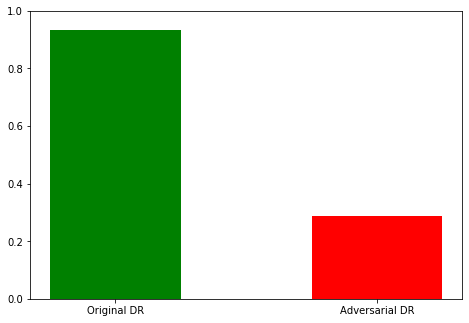

In [39]:
# Matplotlib barplot visualization

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
lab = ["Original DR", "Adversarial DR"]
dr = [recall, adv_recall]
ax.bar(lab, dr, color = ["green", "red"], width = 0.5)
ax = ax.set(ylim = (0, 1))
plt.show()